# Avaliação das previsões geradas pelo modelo ARIMA 

Neste trabalho é avaliada a performance do modelo ARIMA para a previsão da média de casos de 7 dias utilizando dados fora do período de treino do modelo. No trabalho anterior foram testadas modelos AR e MA, mas, como o ARIMa teve desempenho melhor na maioria dos países ele foi o selecionado para prosseguir nesta fase do projeto.

## Bibliotecas necessárias

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

## Leitura dos dados

In [14]:
dir_covid_data = '../../datalake/silver/covid_data/series_with_calc_fields'
covid_file = f'{dir_covid_data}/AR.parquet'
covid_data = pd.read_parquet(covid_file)
covid_data['date'] = pd.to_datetime(covid_data.date)
covid_data = covid_data[((covid_data.date > "2020-01-01") & (covid_data.date < "2020-7-31"))]
covid_data.set_index('date', inplace=True)
reg_data = covid_data[['Country_Region', 'New_Confirmed']].dropna() # Remoção de valores NaN

Função para gerar previsões com o modelo ARIMA

In [21]:
def arima_model(train_data, test_data, p=0, d=0, q=0, country='', model_name='',
                horizon=1, y_lim=6_000, country_plot=''):
    model = ARIMA(train_data['New_Confirmed'], order=(p, d, q))
    model = model.fit()
    fcst = []
    data = train_data.copy()

    for i in range(len(test_data)):
        fcst.append([data.index[-1], *model.forecast(horizon).values[:]])
        data = pd.concat([data, test_data.iloc[i:i+1]])
        model_test = ARIMA(data['New_Confirmed'], order=(p, d, q))
        #model = model_test.fit()
        model = model_test.smooth(model.params)

    fcst = pd.DataFrame(fcst)
    fcst.columns = ['fcst_date', *[f'h{i}' for i in range(1, horizon+1)]]
    fcst.set_index('fcst_date', inplace=True)
    fcst[f'{horizon}day_average'] = fcst.mean(axis=1)
    
    data_fcst = data.loc[fcst.index].rolling(horizon).mean().shift(-horizon).dropna()
    train_avg = data['New_Confirmed'].rolling(horizon).mean()
    fig, ax = plt.subplots(1)
    fcst = fcst.loc[data_fcst.index]
    fcst[f'{horizon}day_average_observed'] = data_fcst
    
    fcst.loc[data_fcst.index][f'{horizon}day_average'].plot(ax=ax, label='Previsão')
    train_avg.plot(ax=ax, label='Série observada')
    
    plt.legend()
    plt.title(f'Média móvel de 7 dias: Previsto x Observado {country_plot}')
    plt.ylim(0, y_lim)
    plt.xlim('2020-03-01', fcst.index[-1])
    
    # ax.set_xticks([], minor=True)
    labels = [datetime.strftime(x, '%d-%m') for x in fcst.index[::5]]
    # ax.set_xticks(ticks=train_avg.index[::5], labels=labels)
    ax.set_ylabel('Número de casos')
    ax.set_xlabel('')
    return fcst

## Gerando Previsões

### Argentina

In [16]:
reg_data_ar = covid_data
reg_data_ar = reg_data_ar[['New_Confirmed']]
reg_data_ar = reg_data_ar.loc[reg_data_ar.ne(0).idxmax()[0]:]
train_data = reg_data_ar.iloc[:103]
test_data = reg_data_ar.iloc[103:]

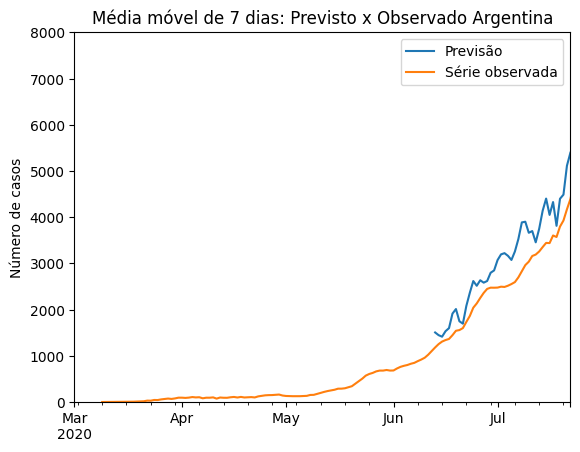

In [22]:
fcst_ar_smooth = arima_model(train_data, test_data,
                      p=1, d=2, q=7, 
                      model_name='ARIMA',
                      country='Argentina', 
                      horizon=7, y_lim=8_000,
                      country_plot = 'Argentina')

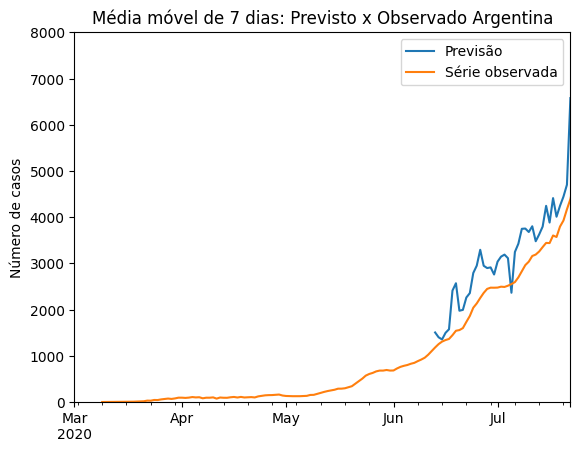

In [18]:
fcst_ar = arima_model(train_data, test_data,
                      p=1, d=2, q=7, 
                      model_name='ARIMA',
                      country='Argentina', 
                      horizon=7, y_lim=8_000,
                      country_plot = 'Argentina')

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from datetime import timedelta

def avalia_previsoes(fcst, test):

    results = []

    for i in range(1, 8):
        fcst_h = fcst[[f'h{i}']]
        fcst_h.index += timedelta(days=i)
        obs = test.loc[fcst_h.index]
        results.append([
            f'h{i}',
            r2_score(obs, fcst_h),
            np.sqrt(mean_squared_error(obs, fcst_h)),
            mean_absolute_error(obs, fcst_h),
            mean_absolute_percentage_error(obs, fcst_h),
            np.corrcoef(obs.values[:, 0], fcst_h.values[:, 0])[0, 1]
        ])

    results.append([
            f'7 dias',
            r2_score(fcst['7day_average_observed'], fcst['7day_average']),
            np.sqrt(mean_squared_error(fcst['7day_average_observed'], fcst['7day_average'])),
            mean_absolute_error(fcst['7day_average_observed'], fcst['7day_average']),
            mean_absolute_percentage_error(fcst['7day_average_observed'], fcst['7day_average']),
            np.corrcoef(fcst['7day_average_observed'],  fcst['7day_average'])[0, 1]
        ])
    results = pd.DataFrame(results, columns=['horizonte', 'r²', 'RMSE', 'MAE', 'MAPE', 'Correl'])
    print(results)
    return results

In [23]:
metricas_ar_smooth = avalia_previsoes(fcst_ar_smooth, test_data)

  horizonte        r²        RMSE         MAE      MAPE    Correl
0        h1  0.858594  432.938596  342.324300  0.118659  0.928176
1        h2  0.809521  517.868323  417.375082  0.142091  0.903483
2        h3  0.695493  651.303313  475.019862  0.148402  0.843404
3        h4  0.670205  664.271797  481.465297  0.145999  0.831054
4        h5  0.687396  642.003379  474.913886  0.141127  0.844104
5        h6  0.743541  607.354150  455.265555  0.132671  0.877070
6        h7  0.751678  612.689044  468.528289  0.132780  0.882646
7    7 dias  0.870660  391.499139  283.427226  0.090562  0.942310


In [20]:
metricas_ar = avalia_previsoes(fcst_ar, test_data)
#metricas_ar.to_csv('../../avaliavao_argentina.csv', index=False)

  horizonte        r²        RMSE         MAE      MAPE    Correl
0        h1  0.819281  489.434265  374.279971  0.127492  0.906490
1        h2  0.780667  555.709136  467.901269  0.163648  0.885685
2        h3  0.618717  728.800793  564.566468  0.176626  0.793271
3        h4  0.600757  730.874187  530.041067  0.161988  0.783772
4        h5  0.611546  715.664987  559.093089  0.166366  0.793195
5        h6  0.687146  670.817007  530.952689  0.157437  0.835988
6        h7  0.653009  724.254907  535.282168  0.148286  0.817754
7    7 dias  0.800419  486.323249  387.819934  0.121046  0.899743


```
  horizonte        r²        RMSE         MAE      MAPE    Correl
0        h1  0.759420  420.125688  331.554652  0.124691  0.876106
1        h2  0.691078  513.264843  434.940162  0.159952  0.837599
2        h3  0.562575  662.384616  538.446944  0.180334  0.766210
3        h4  0.599168  691.352902  529.022510  0.168699  0.794953
4        h5  0.637060  676.554796  518.545844  0.154560  0.829352
5        h6  0.726392  593.113391  453.633774  0.134361  0.889021
6        h7  0.663576  652.703462  532.593427  0.155555  0.848590
7    7 dias  0.791616  434.571356  341.450875  0.112282  0.907457
```

### México

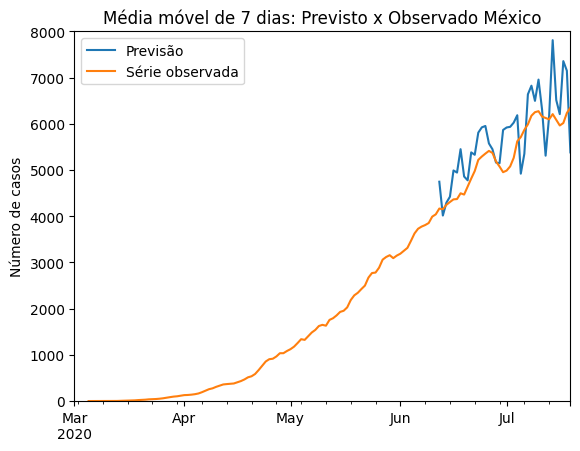

In [96]:
reg_data_mx = reg_data[reg_data['Country/Region'] == 'Mexico']
reg_data_mx = reg_data_mx[['New cases']]
reg_data_mx = reg_data_mx.loc[reg_data_mx.ne(0).idxmax()[0]:]
train_data = reg_data_mx.iloc[:106]
test_data = reg_data_mx.iloc[106:]
fcst_mx = arima_model(train_data, test_data, p=1, d=2, q=9, model_name='ARIMA', country='México', horizon=7,
                      y_lim=8_000, country_plot='México')

In [97]:
metricas_mx = avalia_previsoes(fcst_mx, test_data)
metricas_mx.to_csv('../../avaliavao_mexico.csv', index=False)

  horizonte        r²         RMSE          MAE      MAPE    Correl
0        h1 -0.054644  1149.400422   869.314636  0.161895  0.567086
1        h2 -0.594880  1372.973058  1078.484194  0.195550  0.303281
2        h3 -0.122744  1124.667036   948.985973  0.177576  0.356327
3        h4 -0.250672  1214.098821   995.137777  0.176847  0.271985
4        h5 -0.222888  1219.959585   986.588875  0.173844  0.244149
5        h6  0.318718   908.313917   769.869715  0.137130  0.574246
6        h7  0.378912   868.472952   730.068199  0.128580  0.619576
7    7 dias -0.031614   630.424473   527.701291  0.091901  0.677680


```
  horizonte        r²         RMSE          MAE      MAPE    Correl
0        h1  0.158481  1026.715697   832.119500  0.159479  0.551897
1        h2 -0.497763  1330.514372  1131.952566  0.211261  0.222786
2        h3 -0.924898  1472.608892  1280.708769  0.240312  0.032354
3        h4 -0.922517  1505.280072  1265.070642  0.228563  0.019898
4        h5 -0.554171  1375.312932  1107.940081  0.196261  0.203004
5        h6 -0.006253  1103.890401   874.087221  0.155330  0.490485
6        h7  0.365972   877.473323   726.734854  0.127301  0.678556
7    7 dias -1.017719   881.667239   747.388991  0.131155  0.558364
```

### Chile

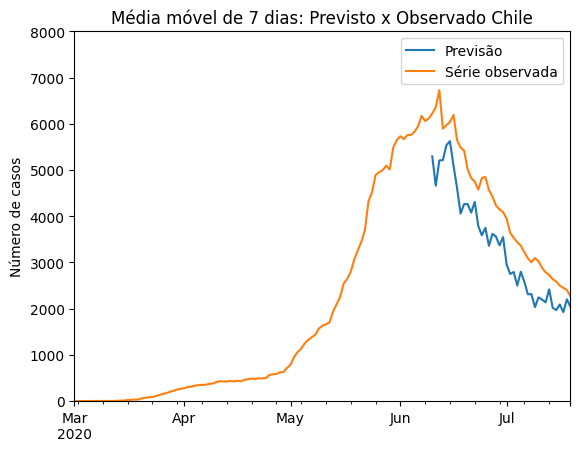

In [98]:
reg_data_ch = reg_data[reg_data['Country/Region'] == 'Chile']
reg_data_ch = reg_data_ch[['New cases']]
reg_data_ch = reg_data_ch.loc[reg_data_ch.ne(0).idxmax()[0]:]
train_data = reg_data_ch.iloc[:109]
test_data = reg_data_ch.iloc[109:]
fcst_ch = arima_model(train_data, test_data, 
                      p=2, d=2, q=4, 
                      model_name='ARIMA',
                      country='Chile', 
                      horizon=7,
                      y_lim=8_000,
                      country_plot='Chile')

In [99]:
metricas_ch = avalia_previsoes(fcst_ch, test_data)
metricas_ch.to_csv('../../avaliavao_chile.csv', index=False)

  horizonte        r²         RMSE         MAE      MAPE    Correl
0        h1  0.508300  1076.078488  885.916736  0.253215  0.741585
1        h2  0.526909  1060.166896  863.683429  0.251871  0.743940
2        h3  0.532371  1019.982388  809.364351  0.246926  0.753789
3        h4  0.366595  1040.631613  800.545332  0.251354  0.684030
4        h5  0.712086   636.952266  497.918417  0.172661  0.860354
5        h6  0.681271   655.311744  521.726746  0.179047  0.849810
6        h7  0.582272   734.620316  572.118444  0.194399  0.793159
7    7 dias  0.897946   348.739746  280.278944  0.079559  0.955695


```
  horizonte        r²         RMSE          MAE      MAPE    Correl

0        h1  0.362638  1225.142959   817.474510  0.252532  0.695238

1        h2  0.287082  1301.433589   880.676718  0.286086  0.649913

2        h3  0.196999  1336.595750   901.625930  0.308384  0.651675

3        h4  0.052576  1272.707209   876.247449  0.310807  0.700759

4        h5 -0.002445  1188.517129   886.421103  0.313898  0.814220

5        h6 -0.152753  1246.251072  1032.899811  0.357996  0.868014

6        h7 -0.600956  1438.156061  1128.954589  0.406498  0.764850

7    7 dias  0.299263   913.825307   746.376489  0.214467  0.929928
```


### Equador

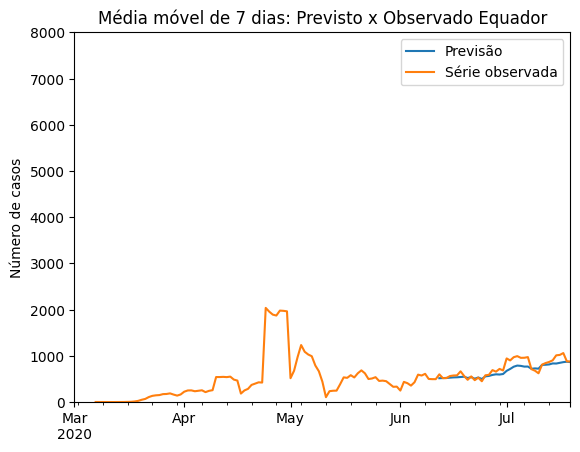

In [100]:
reg_data_eq = reg_data[reg_data['Country/Region'] == 'Ecuador']
reg_data_eq = reg_data_eq[['New cases']]
reg_data_eq = reg_data_eq.loc[reg_data_eq.ne(0).idxmax()[0]:]
train_data = reg_data_eq.iloc[:104]
test_data = reg_data_eq.iloc[104:]
fcst_eq = arima_model(train_data, test_data, p=1, d=1, q=3, model_name='ARIMA', country='Equador', horizon=7, y_lim=8_000,
                      country_plot='Equador')


In [101]:
metricas_eq = avalia_previsoes(fcst_eq, test_data)
metricas_eq.to_csv('../../avaliavao_aequador.csv', index=False)

  horizonte        r²        RMSE         MAE          MAPE    Correl
0        h1 -0.051518  461.024618  323.347359  2.893535e+17  0.147457
1        h2 -0.030483  475.085146  340.081822  2.849436e+17  0.217218
2        h3 -0.047985  476.242524  342.658370  2.856727e+17  0.203991
3        h4 -0.037841  472.528498  341.952537  2.844936e+17  0.234796
4        h5 -0.047095  473.753420  336.562790  2.860256e+17  0.233823
5        h6 -0.049401  472.802782  343.865990  2.794559e+17  0.258671
6        h7 -0.074936  477.922193  350.813583  2.734234e+17  0.217967
7    7 dias -0.279853  204.887604  157.476000  1.819438e-01  0.569908


```
horizonte        r²        RMSE         MAE          MAPE    Correl
0        h1 -0.403339  532.594913  397.401254  2.256880e+17 -0.072107
1        h2 -0.456355  564.786821  427.035817  2.229718e+17 -0.206651
2        h3 -0.511362  571.919397  439.814824  2.228653e+17 -0.172449
3        h4 -0.540822  575.756322  448.249503  2.228598e+17 -0.035049
4        h5 -0.566525  579.466184  455.617253  2.228599e+17 -0.071416
5        h6 -0.608572  585.368745  467.196269  2.228599e+17 -0.085791
6        h7 -0.614653  585.740950  468.538369  2.228599e+17  0.049903
7    7 dias -3.419423  380.731135  335.950462  3.811239e-01  0.023555
```

### Espanha

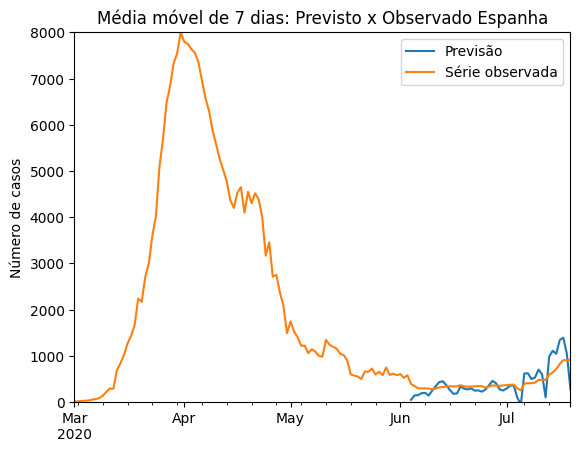

In [102]:
reg_data_es = reg_data[reg_data['Country/Region'] == 'Spain']
reg_data_es = reg_data_es[['New cases']]
reg_data_es = reg_data_es.loc[reg_data_es.ne(0).idxmax()[0]:]
train_data = reg_data_es.iloc[:125]
test_data = reg_data_es.iloc[125:]
fcst_es = arima_model(train_data, test_data,
                      p=2, d=2, q=8, 
                      model_name='ARIMA', 
                      country='Espanha', 
                      horizon=7, y_lim=8_000,
                      country_plot='Espanha')

In [103]:
metricas_es = avalia_previsoes(fcst_es, test_data)
metricas_es.to_csv('../../avaliavao_espanha.csv', index=False)

  horizonte        r²        RMSE         MAE          MAPE    Correl
0        h1  0.084435  691.127176  319.323600  3.629724e+17  0.324833
1        h2  0.142866  677.380256  359.062802  3.950051e+17  0.413376
2        h3  0.333786  604.240934  340.995214  3.415079e+17  0.636874
3        h4  0.254145  687.584231  375.947755  3.270822e+17  0.582472
4        h5  0.164249  756.778819  427.706034  3.457694e+17  0.507463
5        h6  0.314068  688.520098  397.213080  3.227344e+17  0.658660
6        h7  0.398812  647.772200  370.933659  2.632491e+17  0.758846
7    7 dias  0.447231  327.395849  215.613005  3.569174e-01  0.796618


```
  horizonte        r²        RMSE         MAE          MAPE    Correl
0        h1 -0.118200  763.788636  342.060135  3.797555e+17  0.062529
1        h2 -0.048085  749.042543  395.550170  4.369714e+17  0.189015
2        h3  0.168885  674.891469  385.344134  3.861019e+17  0.467980
3        h4  0.086289  761.032584  431.072526  3.645480e+17  0.408341
4        h5 -0.004311  829.592262  471.342965  3.980390e+17  0.344476
5        h6  0.210440  738.700901  413.647384  2.883948e+17  0.582341
6        h7  0.361927  667.347990  392.202226  2.503772e+17  0.738080
7    7 dias  0.340237  357.680475  232.064585  3.895906e-01  0.754491
```

In [104]:
fcst_es.head()

,h1,h2,h3,h4,h5,h6,h7,7day_average,7day_average_observed
fcst_date,,,,,,,,,
2020-06-04,116.483126,206.559665,26.164996,-3.095472,86.096498,-39.159520,-52.876183,48.596158,292.428571
2020-06-05,266.715933,135.337885,91.365851,221.909332,49.344638,123.591559,111.147266,142.773209,318.714286
2020-06-06,154.825564,126.732907,252.509996,93.341350,152.261527,168.313919,104.101581,150.298121,327.857143
2020-06-07,152.157044,298.651286,133.263568,209.660816,205.716212,178.682402,170.211577,192.620415,339.714286
2020-06-08,303.081676,141.304197,216.617596,215.718572,185.199878,183.207923,151.790812,199.560093,341.714286


In [105]:
fcst_es.tail()

,h1,h2,h3,h4,h5,h6,h7,7day_average,7day_average_observed
fcst_date,,,,,,,,,
2020-07-15,911.404679,1210.852682,521.428314,1218.756375,1292.731941,1003.218320,1160.480379,1045.553241,1436.714286
2020-07-16,1344.955827,764.859820,1429.309223,1595.494968,1200.364288,1553.836047,1522.941884,1344.537437,1615.857143
2020-07-17,781.277999,1459.112489,1621.272815,1237.431413,1577.972340,1571.100173,1504.126674,1393.184843,1738.000000
2020-07-18,1226.080353,1198.257890,871.552851,1051.858448,1228.523215,820.590485,908.563950,1043.632456,1738.000000
2020-07-19,832.557128,207.707818,477.680464,402.884868,282.983282,-164.118578,-77.741141,280.279120,1738.000000
